### IU Sketch Baseline 코드  
 - python모듈 설치 코드는 처음 한번 실행해주세요.     


In [ ]:
# !pip install imageio
# !pip install imageio --upgrade
# !pip install einops

In [1]:
# 모듈 path 설정.
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))

베이스 라인 코드.  

In [2]:
import os, glob, random
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ThresholdedReLU

from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import apps.config_env as cfg

from classes.image_frame import ImgFrame
from classes.video_clip import VideoClip
from models.dataset_generator import DataSetGenerator
from models.draw_generator import DrawGenerator

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

# from models.layer_conv import Conv2Plus1D, TConv2Plus1D
# from models.layer_encoder import Encoder5D, Decoder5D
# from models.layer_lstm import ConvLstmSeries

from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())

2023-02-02 14:14:48.046498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 14:14:48.265708: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-02 14:14:49.214919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 14:14:49.215031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17187836877807923279
xla_global_id: -1
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


2023-02-02 14:14:50.974055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 14:14:51.006524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 14:14:51.006923: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/evergrin/anaconda3/envs/pyenv_3912/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-02 14:14:51.007000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

In [3]:
# 필요한 디렉토리 없으면 생성.

# 학습용 raw_clip(gif) 파일 위치.
if not os.path.exists(cfg.RAW_CLIP_PATH):
    os.mkdir(cfg.RAW_CLIP_PATH)

# 모델 저장 위치
if not os.path.exists(cfg.MODEL_SAVE_PATH):
    os.mkdir(cfg.MODEL_SAVE_PATH)

# 임시 데이터 저장 위치
if not os.path.exists(cfg.TEMP_DATA_PATH):
    os.mkdir(cfg.TEMP_DATA_PATH)

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 15    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def plot_history(history):
    
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['tgen_loss'])  
    plt.plot(history['tdisc_loss'])  
    plt.plot(history['tl1_loss'])  
    plt.plot(history['vgen_loss'])  
    plt.plot(history['vdisc_loss'])  
    plt.plot(history['vl1_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['tgen_loss', 'tdisc_loss', 'tl1_loss', 'vgen_loss', 'vdisc_loss', 'vl1_loss'], loc='upper right')  

    # summarize history for accuracy  
    # plt.subplot(212)  
    # plt.plot(history['fake_accuracy'])  
    # plt.plot(history['real_accuracy'])  
    # plt.title('discriminator accuracy')  
    # plt.ylabel('accuracy')  
    # plt.xlabel('batch iters')  
    # plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper right')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    # plt.savefig(os.path.join(history_path, 'train_history_{:04d}.png'.format(epoch)))
    plt.show()

In [5]:
def arry5d_to_img(arry5d, save_as='', threshold=0.0):
    frmimg_cnt = arry5d.shape[1]
    fig, axes = plt.subplots(nrows = 1, ncols = frmimg_cnt, figsize=(15, 3))

    for idx, num in enumerate(range(0, frmimg_cnt)):
        frm = ImgFrame(img=arry5d[0][idx][:, :, :], do_norm=False)
        min_val = np.min(frm.arry)
        max_val = np.max(frm.arry)
        frm.arry = (frm.arry - min_val) / (max_val - min_val)

        min_val = np.min(frm.arry)
        max_val = np.max(frm.arry)
        # print("min,max: ", np.min(frm.arry), np.max(frm.arry))

        if threshold > 0.0:
            frm.threshold(threshold=threshold)

        img = frm.to_flatten_image()
        axes[idx].imshow(img, cmap='gray')

    plt.show()


def show_imgs(arry1, arry2, save_path=""):
    frmimg_cnt = arry1.shape[1]
    fig, axes = plt.subplots(nrows = 2, ncols = frmimg_cnt, figsize=(15, 3))
    arrys = [arry1, arry2]
    
    for i, arry in enumerate(arrys):
        for idx, num in enumerate(range(0, frmimg_cnt)):
            frm = ImgFrame(img=arry[0][idx][:, :, :], do_norm=False)
            min_val = np.min(frm.arry)
            max_val = np.max(frm.arry)
            frm.arry = (frm.arry - min_val) / (max_val - min_val)

            min_val = np.min(frm.arry)
            max_val = np.max(frm.arry)
            # print("min,max: ", np.min(frm.arry), np.max(frm.arry))

            img = frm.to_image()
            axes[i][idx].imshow(img, cmap='gray')

    if save_path != "":
        plt.savefig(save_path)
    
    plt.show()


In [6]:
img_w, img_h = 64, 64 #cfg.DATA_IMG_W, cfg.DATA_IMG_H
batch_size = 5 #cfg.DATA_BATCH_SIZE
time_steps = 5 # cfg.DATA_TIME_STEP
enc_blk_count = 5  # 3 - 7
disc_blk_count = 3 # 
EPOCHS = 100

enc_filters = [64,128,256,512,512,512,512,512]
dec_filters = [512,512,512,512,256,128,64]
use_conv2n1 = False
train_lamda = 100

# discriminator augmentation
use_ada = False
ada_p = 0.7
ada_lamda1 = 10
ada_lamda2 = 10

# dataset 설정.
data_seq_type = 'aforward'  # 'all', 'rest', 'arandom', 'aforward', 'forward', 'reverse', 'random'
data_label_type = '1step'   # 'all', 'rest', 'same', '1step'
stakced = True
overlap = False
fill_box = False
invert = False

save_load_prefix = "test_00"
save_load_preload = False
save_load_interval = 0

# 전체 raw_clip 랜덤한 이미지 목록을 가져옴.
img_list = glob.glob(os.path.join(cfg.RAW_CLIP_PATH, "*.gif"))
random.shuffle(img_list)

# 이미지 목록을 train/validation용으로 9:1로 나눔.
train_val_ratio = 0.9
train_img_cnt = int(len(img_list) * train_val_ratio)
train_img_list = img_list[:train_img_cnt]
val_img_list = img_list[train_img_cnt:]

# train/validation용 generator를 생성.
# tdgen = DataSetGenerator(imgs=train_img_list, batch_size=batch_size, 
#                          time_step=time_steps, imgw=img_w, imgh=img_h, 
#                          seq_type=data_seq_type, label_type=data_label_type,
#                          stacked=stakced, overlap=overlap, fill_box=fill_box, invert=invert)

# vdgen = DataSetGenerator(imgs=val_img_list, batch_size=batch_size, 
#                          time_step=time_steps, imgw=img_w, imgh=img_h, 
#                          seq_type=data_seq_type, label_type=data_label_type,
#                          stacked=stakced, overlap=overlap, fill_box=fill_box, invert=invert)

tdgen = DrawGenerator(imgs=train_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h)

vdgen = DrawGenerator(imgs=val_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h)

In [9]:
# show sample data
it = iter(tdgen)
x, y = next(it)

print(f"train data : {len(train_img_list)}, val data : {len(val_img_list)}")
print(f"x type: {x.shape}, y type: {y.shape}")

arry5d_to_img(x, threshold=0.)

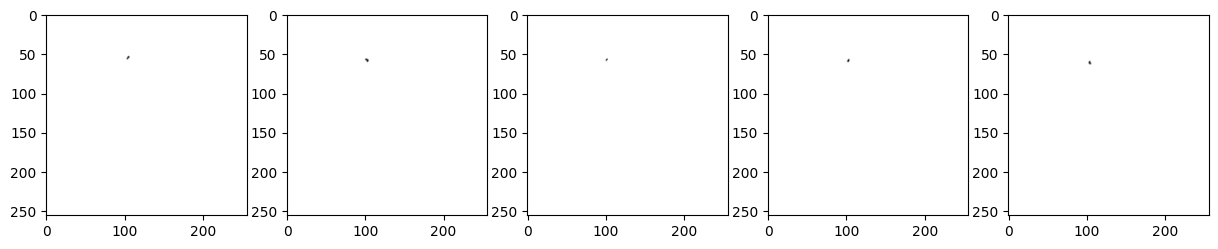

In [8]:
arry5d_to_img(y, threshold=0.)

In [ ]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv3D(filters=n_filters,
                    kernel_size=(1, 4, 4),
                    strides=(1, 2, 2),
                    padding="same")
        self.conv2 = layers.Conv3D(filters=n_filters,
                    kernel_size=(4, 1, 1),
                    strides=1,
                    padding="same")        
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x, training=False):
        x = self.conv(x, training=training)
        if use_conv2n1:
            x = self.conv2(x, training=training)
        if self.use_bn:
            x = self.batchnorm(x, training=training)
#         x = layers.Dropout(.5)(x, training=training)
        return self.lrelu(x)


class Encoder(Model):
    def __init__(self, blk_cnt=5):
        super(Encoder, self).__init__()
#         filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i in range(blk_cnt):
            f = enc_filters[i]
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x, training=False):
        for block in self.blocks:
            x = block(x, training=training)
        return x
    
    def get_summary(self, input_shape=(None, img_w, img_h, 1)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [ ]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv3DTranspose(filters=f,
                    kernel_size=(1, 4, 4),
                    strides=(1, 2, 2),
                    padding="same")
        self.Transconv2 = layers.Conv3DTranspose(filters=f, 
                    kernel_size=(4, 1, 1),
                    strides=1,
                    padding="same")        
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x, training=False):
        x = self.Transconv(x, training=training)
        if use_conv2n1:
            x = self.Transconv2(x, training=training)
        x = self.batchnorm(x, training=training)
        if self.dropout:
            x = layers.Dropout(.5)(x, training=training)
        return self.relu(x)

    
class Decoder(Model):
    def __init__(self, blk_cnt=4):
        super(Decoder, self).__init__()
#         filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i in range(blk_cnt):
            f = dec_filters[i - blk_cnt]
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv3DTranspose(filters=1,
                    kernel_size=(1, 4, 4),
                    strides=(1, 2, 2),
                    padding="same"))
        if use_conv2n1:
            self.blocks.append(layers.Conv3DTranspose(filters=1,
                    kernel_size=(4, 1, 1),
                    strides=(1, 1, 1),
                    padding="same"))
        
    def call(self, x, training=False):
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class ConvLstmSeries(Model):
    '''
        5-rank Colvolution LSTM
    '''
    def __init__(self, filter_cnt, final_filter_cnt, kernel_sizes):
        """
            (b, t, h, w, c) -> (b, t, h/stride, w/stride, f)
            A sequence of convolutional layers that first apply the convolution operation over the
            spatial dimensions, and then the temporal dimension.
        """
        super(ConvLstmSeries, self).__init__()
        self.filter_cnt = filter_cnt
        self.final_filter_cnt = final_filter_cnt
        self.kernel_cnt = len(kernel_sizes)
        self.lstms = []
        self.bns = []
        self.relus = []
        self.out_conv = None

        for kernel_size in kernel_sizes:
            self.lstms.append(layers.ConvLSTM2D(
                                filters=filter_cnt,
                                kernel_size=kernel_size,
                                padding="same",
                                return_sequences=True,
                                #recurrent_activation='hard_sigmoid', # other nan... layers.ReLU(), #layers.LeakyReLU(0.2), #'hard_sigmoid',
                                activation=layers.ReLU(), #layers.LeakyReLU(0.2), #"relu",
                                kernel_regularizer="l2",
                                recurrent_regularizer="l2",
                                activity_regularizer="l2",
                            ))
            self.bns.append(layers.BatchNormalization())
            self.relus.append(layers.LeakyReLU(0.2)) #layers.ReLU()

        # 출력의 channel depth를 맞춰주기 위해.
        if final_filter_cnt > 0:
            self.out_conv = layers.Conv3D(filters=final_filter_cnt,
                    kernel_size=(1, 3, 3),
                    strides=(1, 1, 1),
                    padding="same")
            self.out_bn = layers.BatchNormalization()
            self.out_relu = keras.activations.sigmoid # layers.LeakyReLU(0.2) # keras.activations.sigmoid # layers.ReLU()

    def call(self, x, training=False):
        for idx in range(self.kernel_cnt):
            x = self.lstms[idx](x, training=training)
            x = self.bns[idx](x, training=training)
            x = layers.Dropout(.5)(x, training=training)
            x = self.relus[idx](x)

        if self.out_conv is not None:
            x = self.out_conv(x, training=training)
            x = self.out_bn(x, training=training)
            x = layers.Dropout(.5)(x, training=training)
            x = self.out_relu(x)

        return x

In [ ]:
class EncoderDecoderGenerator(Model):
    def __init__(self, blk_cnt=4):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder(blk_cnt)
        self.decoder = Decoder(blk_cnt-1)
        
        lstm_filters = enc_filters[blk_cnt-1]
        self.lstms = ConvLstmSeries(lstm_filters, 0, [(5, 5), (3, 3), (1, 1)])
#         self.lstms = ConvLstmSeries(lstm_filters, 1, [(3, 3), (3, 3), (3, 3)])
    
    ''' 
        아래와 같이 순서와 조합을 바꾸면 다른 모델이 됨.
        이때 loss 및 save/load도 같이 바뀌므로 주의.
            1. encoder - decoder(pix2pix gan model)
            2. lstms
            3. encoder(pretrained) - lstms - decoder(pretrained)
            4. lstms(pre-trained) - encoder - decoder
    '''
    def call(self, x, training=False):
        x = self.encoder(x, training=training)
        # x = self.lstms(x, training=training)
        x = self.decoder(x, training=training)
        return x
   
    def get_summary(self, input_shape=(None, img_w, img_h, 1)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=0, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        # outputsize = (w - f + 2*p) / s + 1
        if custom_pad > 0:
            self.padding = layers.ZeroPadding3D(padding=(0,custom_pad,custom_pad))
            self.conv = layers.Conv3D(filters=n_filters,
                    kernel_size=(1, 4, 4),
                    strides=(1, stride, stride),
                    padding="valid")
            self.conv2 = layers.Conv3D(filters=n_filters,
                    kernel_size=(4, 1, 1),
                    strides=(1, 1, 1),
                    padding="valid")
        else:
            self.conv = layers.Conv3D(filters=n_filters,
                    kernel_size=(1, 4, 4),
                    strides=(1, stride, stride),
                    padding="same")
            self.conv2 = layers.Conv3D(filters=n_filters,
                    kernel_size=(4, 1, 1),
                    strides=(1, 1, 1),
                    padding="same")
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x, training=False):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x, training=training)
            if use_conv2n1:
                x = self.conv2(x, training=training)
        else:
            x = self.conv(x, training=training)
            if use_conv2n1:
                x = self.conv2(x, training=training)
            
        if self.use_bn:
            x = self.batchnorm(x, training=training)

        if training:
            x = layers.Dropout(.5)(x, training=training)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [ ]:
class Discriminator(Model):
    def __init__(self, blk_cnt=3):
        super(Discriminator, self).__init__()

        self.concat = layers.Concatenate()

        filters = [64,128,256,512,512,512]
        self.blocks = []
        for i in range(blk_cnt):
            f = filters[i]
            self.blocks.append(DiscBlock(
                n_filters=f,
                stride=2,
                custom_pad=0,
                use_bn=False if i==0 else True,
                act=True
            ))

        self.blocks.append(DiscBlock(n_filters=512, stride=1, custom_pad=1, use_bn=True, act=True))
        self.blocks.append(DiscBlock(n_filters=1, stride=1, custom_pad=1, use_bn=False, act=False))
        self.sigmoid = layers.Activation("sigmoid")


    def call(self, x, y, training=False):
        out = self.concat([x, y])
        
        for block in self.blocks:
            out = block(out, training=training)
            
        # if training:
        #     out = layers.Dropout(.5)(out)
                
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(None, img_w, img_h, 1), y_shape=(None, img_w, img_h, 1)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    '''
    모델학습 초기에 learning rate를 급격히 높였다가, 
    서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법
    학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소
    '''
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
class ADA(layers.Layer):
    def __init__(self):
        super(ADA, self).__init__()
        self.flip = tf.image.flip_left_right
        self.rot90 = tf.image.rot90
        self.resize = tf.image.resize  # (sie, method, preserve_aspect_ratio)
        self.cropnresize = tf.image.crop_and_resize #(image, boxes,box_indices,crop_size,method='bilinear',extrapolation_value=0.0,

    
    def call(self, x):
        x_shape = x.shape
        x_batch = x_shape[0]*x_shape[1]
        x_h, x_w = (x_shape[2], x_shape[3])
        x_channel = x_shape[4]

        # 5d tensor -> 4d tensor
        x1 = tf.reshape(x, [x_batch, x_h, x_w, x_channel])

        x1 = self.flip(x1)
        x1 = self.rot90(x1)
        x1 = self.resize(x1, [int(x_h*1.5), int(x_w*1.5)])
        x1 = self.resize(x1, [x_h, x_w])
        
        # 4d tensor -> 5d tensor
        x2 = tf.reshape(x1, x_shape)
        return x2


In [ ]:
bce = losses.BinaryCrossentropy(from_logits=True) # False
mae = losses.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
poisson = tf.keras.losses.Poisson()
ada_loss = mse

def dice_score_loss(y_true, y_pred):
    numerator = 2. * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return tf.reduce_mean(1 - numerator / denominator)

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [ ]:
# gene_learning_rate = CustomSchedule(d_model=64, warmup_steps=5000)
# disc_learning_rate = CustomSchedule(d_model=64, warmup_steps=5000)
# gene_opt = optimizers.Adam(gene_learning_rate, beta_1=.5, beta_2=.999)
# disc_opt = optimizers.Adam(disc_learning_rate, beta_1=.5, beta_2=.999)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
generator = EncoderDecoderGenerator(blk_cnt=enc_blk_count)
discriminator = Discriminator(blk_cnt=disc_blk_count)
ada = ADA()

generator.get_summary()
discriminator.get_summary()

# plot_model(discriminator, show_shapes=True, show_layer_names=True, expand_nested=True)

history = {'tgen_loss':[], 'tdisc_loss':[], 'tl1_loss':[], 'vgen_loss':[], 'vdisc_loss':[], 'vl1_loss':[]}

In [ ]:
''' gan model(train step)을 사용하지 않고 학습할때  '''

# generator.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
# )

# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# generator.fit(
#     tdgen,
#     batch_size=batch_size,
#     epochs=EPOCHS,
#     validation_data=vdgen,
#     callbacks=[early_stopping, reduce_lr],
# )

In [ ]:
def load_all(prefix='lstm_only_500'):
    save_path = os.path.join(cfg.MODEL_SAVE_PATH, prefix)
#     generator.lstms.load_weights(os.path.join(save_path, f"lstm_{prefix}"))
    generator.encoder.load_weights(os.path.join(save_path, f"encoder_{prefix}"))
    generator.decoder.load_weights(os.path.join(save_path, f"decoder_{prefix}"))

    discriminator.load_weights(os.path.join(save_path, f"disc_{prefix}"))
    
    hist_file = os.path.join(save_path, f"history_{prefix}.pic")

    with open(file=hist_file, mode='rb') as f:
        loaded_history = pickle.load(f)
    
    print(f'{prefix} loaded...')
    return loaded_history

In [ ]:
def save_all(prefix='base_200'):
    save_path = os.path.join(cfg.MODEL_SAVE_PATH, prefix)
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
#     generator.lstms.save_weights(os.path.join(save_path, f"lstm_{prefix}"))
    generator.encoder.save_weights(os.path.join(save_path, f"encoder_{prefix}"))
    generator.decoder.save_weights(os.path.join(save_path, f"decoder_{prefix}"))

    discriminator.save_weights(os.path.join(save_path, f"disc_{prefix}"))

    hist_file = os.path.join(save_path, f"history_{prefix}.pic")
    with open(file=hist_file, mode='wb') as f:
        pickle.dump(history, f)
        
    print(f'{prefix} saved...')

In [ ]:
if save_load_preload:
    try:
        history = load_all(prefix=save_load_prefix)
    except:
        print('preload weight failed !!!')

In [ ]:

@tf.function
def train_step(sketch, label, idx):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_label = generator(sketch, training=True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_label, training=True)
        real_disc = discriminator(sketch, label, training=True)

        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_label, label, fake_disc)
        gene_total_loss = gene_loss + (train_lamda * l1_loss) ## <===== L1 손실 반영 λ=100

        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
        if use_ada and random.random() < ada_p:
            # Discriminator aug 예측
            fake_aug = ada(fake_label)
            sketch_aug = ada(sketch)
            label_aug = ada(label)

            fake_aug_disc = discriminator(sketch_aug, fake_aug, training=False)
            real_aug_disc = discriminator(sketch_aug, label_aug, training=False)

            fake_aug_loss = ada_loss(fake_aug_disc, fake_disc)
            real_aug_loss = ada_loss(real_aug_disc, real_disc)
            
            disc_total_loss = disc_loss + fake_aug_loss*ada_lamda1 + real_aug_loss*ada_lamda2

            #tf.print(disc_loss, fake_aug_loss, real_aug_loss, disc_total_loss)
        else:
            disc_total_loss = disc_loss
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_total_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    # disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_total_loss


In [ ]:
def val_step(sketch, label):
    # Generator 예측
    fake_label = generator(sketch, training=False)

    # Discriminator 예측
    fake_disc = discriminator(sketch, fake_label, training=False)
    real_disc = discriminator(sketch, label, training=False)

    # Generator 손실 계산
    gene_loss, l1_loss = get_gene_loss(fake_label, label, fake_disc)
    gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100

    # Discrminator 손실 계산
    disc_loss = get_disc_loss(fake_disc, real_disc)

    return gene_loss, l1_loss, disc_loss


In [ ]:
it = iter(vdgen)

def show_predicts(cnt=3, save_path=""):
    # dataset중 첫번째만 뽑아서 예측에 입력
    try:
        x, y = next(it)
    except Exception as e:
        it = iter(vdgen)
        x, y = next(it)

    # 연속 예측한 이미지 3개 표시.
    frame_cnt = x.shape[1]
    in_x = x[:1, :-cnt+1, :, :, :]
    in_y = y[:1, :, :, :, :]

    for i in range(cnt):
        pred = generator(in_x)
        in_x = np.append(in_x, pred[:, -1:, :, :, :], axis=1)

    show_imgs(y[:, -5:], in_x[:, -5:], save_path=save_path)

In [ ]:
print("================================= config =================================")
print(f"img size : {img_w}x{img_h}")
print(f"data : ({data_seq_type}, {data_label_type}, {time_steps}frames), stacked:{stakced}, overlap:{overlap}, fill_box : {fill_box}")
print(f"enc_blk : {enc_blk_count}, disc_blk : {disc_blk_count}, ada : {use_ada} ")
print(f"use_conv2n1 : {use_conv2n1}, disc_blk : {disc_blk_count}, ada : {use_ada} ")
print("==========================================================================\n")

train_lamda = 100
ada_lamda1 = 10
ada_lamda2 = 10

In [ ]:
# EPOCHS = 1000

tit = iter(tdgen)
vit = iter(vdgen)

train_step_cnt = 2
val_step_cnt = 1

tg_loss, tl1_loss, td_loss = 0., 0., 0. 
vg_loss, vl1_loss, vd_loss = 0., 0., 0. 

print(f"train started (batch: {batch_size}, epoch: {EPOCHS}, tstep:{train_step_cnt}, vstep:{val_step_cnt})")

batch_start = time()
img_idx = 0

for epoch in range(EPOCHS):

    start = time()

    # train loop
    g_losses = []
    d_losses = []
    l1_losses = []
    for loop in range(train_step_cnt):

        print(f"\rT {epoch + 1:4d} {loop+1:3d}", end="")

        try:
            x, y = next(tit)
        except Exception as e:
            tit = iter(tdgen)
            x, y = next(tit)

        tg_loss, tl1_loss, td_loss = train_step(x, y, loop)

        g_losses.append(tg_loss.numpy())
        d_losses.append(td_loss.numpy())
        l1_losses.append(tl1_loss.numpy())

    tg_loss = np.average(np.array(g_losses))
    td_loss = np.average(np.array(d_losses))
    tl1_loss = np.average(np.array(l1_losses))
    
    history['tgen_loss'].append(tg_loss)
    history['tdisc_loss'].append(td_loss)
    history['tl1_loss'].append(tl1_loss)
        
    # validation loop
    g_losses = []
    d_losses = []
    l1_losses = []
    for loop in range(val_step_cnt):

        print(f"\rV {epoch + 1:4d} {loop+1:3d}", end="")

        try:
            x, y = next(vit)
        except Exception as e:
            vit = iter(vdgen)
            x, y = next(vit)

        vg_loss, vl1_loss, vd_loss = val_step(x, y)

        g_losses.append(vg_loss.numpy())
        d_losses.append(vd_loss.numpy())
        l1_losses.append(vl1_loss.numpy())

    vg_loss = np.average(np.array(g_losses))
    vd_loss = np.average(np.array(d_losses))
    vl1_loss = np.average(np.array(l1_losses))

    history['vgen_loss'].append(vg_loss)
    history['vdisc_loss'].append(vd_loss)
    history['vl1_loss'].append(vl1_loss)
    
    if save_load_interval > 0 and epoch > 0 and epoch % save_load_interval == 0:
        save_all(prefix=save_load_prefix)
        clear_output(wait=True)

        img_save_path = os.path.join(cfg.MODEL_SAVE_PATH, save_load_prefix, "imgs")
        if not os.path.exists(img_save_path):
            os.mkdir(img_save_path)

        img_save_file = os.path.join(img_save_path, f'result_{img_idx:04d}.png')
        while os.path.exists(img_save_file):
            img_idx += 1        
            img_save_file = os.path.join(img_save_path, f'result_{img_idx:04d}.png')

        show_predicts(save_path=img_save_file)

    end = time()
    elapsed_time = int(end-start)

    print(f"\r{epoch + 1:4d} {elapsed_time: 3d}s ",
            f"train g-loss:{tg_loss:.2f}  L1:{tl1_loss:.2f}  d-loss:{td_loss:.2f} ", 
            f"val g-loss:{vg_loss:.2f}  L1:{vl1_loss:.2f}  d-loss:{vd_loss:.2f}")

batch_end = time()
batch_time = int(batch_end-batch_start)
        
print(f"train completed ({batch_time//60}m {batch_time%60}s)")

In [ ]:
save_all(prefix=save_load_prefix)

In [ ]:
# history = load_all(prefix=save_load_prefix)

In [ ]:
plot_history(history)

In [ ]:
show_predicts()

In [ ]:
show_predicts()

In [ ]:
show_predicts()